In [1]:
import os 
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="config")
    print(cfg)

{'num_codebook': 2048, 'reduced_dim': 90, 'projection_dim': 2048, 'dim': None, 'num_queries': None, 'device': None, 'distributed': False, 'load_segment': False, 'load_cluster': False, 'mediator_epoch': 1, 'front_epoch': 2, 'fine_tune_epoch': 1, 'batch_size': 16, 'learning_rate': 0.001, 'num_workers': 2, 'thresh_pos': 0.3, 'thresh_neg': 0.1, 'temp': 0.1, 'grid': False, 'degree_of_sampling': 2, 'patch_size': 320, 'train_resolution': 320, 'patches_shape': None, 'std_mean_path': None, 'overlap_fraction': 0.2, 'max_images': 10, 'crf_max_iter': 100, 'gpu': '0', 'port': '12355', 'dataset': {'data_dir': 'D:/Data/CAUSE_data', 'dst': 'limestone', 'n_classes': 2, 'patchify': False, 'standardization': False}, 'model': {'ckpt': 'D:/git/analytics_2/checkpoints_med/dinomed_vit_base_16.pth', 'run_name': 'train_dino'}}


In [2]:
from tqdm.auto import tqdm
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from torchmetrics.segmentation import MeanIoU

#custom functionality 
from utils.utils import *
from loader.dataloader import dataloader
from loader.netloader import network_loader, cluster_tr_loader, segment_tr_loader
from modules.segment_module import compute_modularity_based_codebook, transform, untransform, quantize_index

d:\git\analytics_2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
scaler = GradScaler()

In [4]:
        cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        if 'dinov2' in cfg.model.ckpt:
            cfg.train_resolution = 322
            
        if 'small' in cfg.model.ckpt:
            cfg.dim = 384
        elif 'base' in cfg.model.ckpt:
            cfg.dim = 768
        
        #set patches_shape for inference stage
        cfg.patches_shape = (9,9)
        
        # Calculate number of queries based on patch size
        patch_size = int(cfg.model.ckpt.split('_')[-1].split('.')[0])
        cfg.num_queries = (cfg.train_resolution ** 2 // 
                                    patch_size ** 2)

In [5]:
cfg.std_mean_path = os.path.join(cfg.dataset.data_dir, cfg.dataset.dst, f'{cfg.dataset.dst}_std_mean')
cfg.dataset.data_dir = os.path.join(cfg.dataset.data_dir, cfg.dataset.dst)
cfg.dataset.dst = f'{cfg.dataset.dst}_patches'

In [6]:
train_loader, _ = dataloader(cfg) 

In [7]:
cfg.degree_of_sampling

2

_IncompatibleKeys(missing_keys=[], unexpected_keys=['register_tokens'])


[Train] Modulatiry_loss: -0.000281: 100%|██████████| 254/254 [00:23<00:00, 10.73it/s]


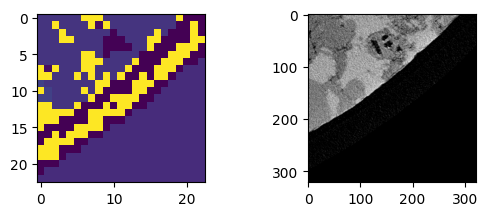

[Train] Modulatiry_loss: -0.000284: 100%|██████████| 254/254 [00:23<00:00, 10.76it/s]


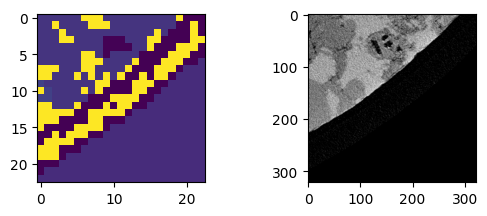

[Train] Modulatiry_loss: -0.000285: 100%|██████████| 254/254 [00:23<00:00, 10.70it/s]


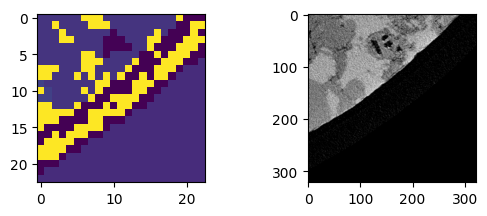

In [ ]:
net = network_loader(cfg, 0)
cluster = cluster_tr_loader(cfg, 0)
segment = segment_tr_loader(cfg, 0)

optimizer = torch.optim.Adam(cluster.parameters(), cfg.learning_rate * 1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

# intermediate feature
for i in range(3):
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    prog_bar.set_description("[Train]")
    for idx, batch in prog_bar:
        img = batch["img"].to(cfg.device)

        # intermediate feature
        with autocast():
            feat = net(img)[:, 1:, :]

            # computing modularity based codebook
            loss_mod = compute_modularity_based_codebook(cluster.codebook, feat, temp=cfg.temp, k=cfg.degree_of_sampling, grid=cfg.grid)

        # optimization
        optimizer.zero_grad()
        scaler.scale(loss_mod).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # real-time print
        desc = f'[Train] Modulatiry_loss: {loss_mod / (idx + 1):.6f}'
        prog_bar.set_description(desc, refresh=True)
        # break

    quant_ind_320 = quantize_index(feat, cluster.codebook)
        
    scheduler.step()
        
    ind = 0
    plt.subplot(221)
    plt.imshow(quant_ind_320.reshape(2, 23, 23)[ind].cpu())
    plt.subplot(222)
    plt.imshow(img[ind].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
    plt.show()
    plt.close()

## CRF-tests

In [ ]:
# cfg.load_segment = True
# cfg.load_cluster = True
# cfg.num_codebook = 4096
# cfg.batch_size = 8
# cfg.thresh_neg = 0.3
# cfg.temp = 0.3
# cfg.model.run_name = f'codebook_{cfg.num_codebook}_batch_size_{cfg.batch_size}_temp_{cfg.temp}_thresh_neg_{cfg.thresh_neg}'
train_loader, _ = dataloader(cfg) 

In [8]:
data_iter = iter(train_loader)
for i in range(10):  # Get 3 batches
    batch = next(data_iter)
    # Process batch here
    print(f"Batch {i+1} shape: {batch['img'].shape}")
    break

Batch 1 shape: torch.Size([16, 3, 320, 320])


In [9]:
img = batch["img"].to(cfg.device)

In [10]:
cfg.device = 'cpu'

In [11]:
net = network_loader(cfg, 0)
# cluster = cluster_tr_loader(cfg, 0)
# segment = segment_tr_loader(cfg, 0)

<All keys matched successfully>


In [165]:
paths = pickle_path_and_exist(cfg)

# early save for time
if paths['modular_exists']:
    codebook = np.load(paths['modular_path'])
    cb = torch.from_numpy(codebook).to(cfg.device)
    cluster.codebook.data = cb
    cluster.codebook.requires_grad = False
    segment.head.codebook = cb
    segment.head_ema.codebook = cb

In [166]:
# intermediate feature
feat = net(img)[:, 1:, :]
feat_flip = net(img.flip(dims=[3]))[:, 1:, :]

seg_feat = transform(segment.head_ema(feat))
seg_feat_flip = transform(segment.head_ema(feat_flip))
seg_feat = untransform((seg_feat + seg_feat_flip.flip(dims=[3])) / 2)

# interp feat
interp_seg_feat = F.interpolate(transform(seg_feat), img.shape[-2:], mode='bilinear', align_corners=False)

# cluster preds
cluster_preds = cluster.forward_centroid(untransform(interp_seg_feat), crf=True)

In [182]:
indx = 3
_, invTrans = get_norm_transforms(cfg)

image = np.array(VF.to_pil_image(invTrans(img.detach().cpu()[indx])))[:, :, ::-1]
H, W = image.shape[:2]
image = np.ascontiguousarray(image)

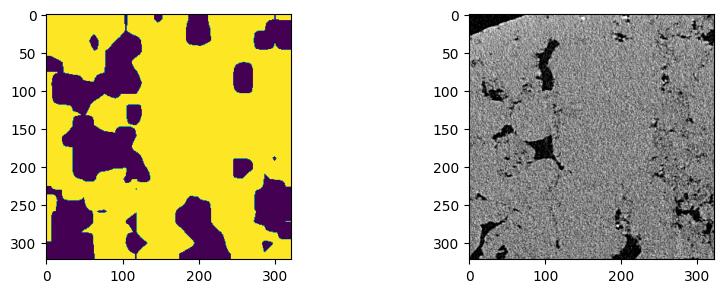

In [183]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.imshow(cluster_preds[indx].detach().cpu().permute(1, 2, 0).argmax(2))
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

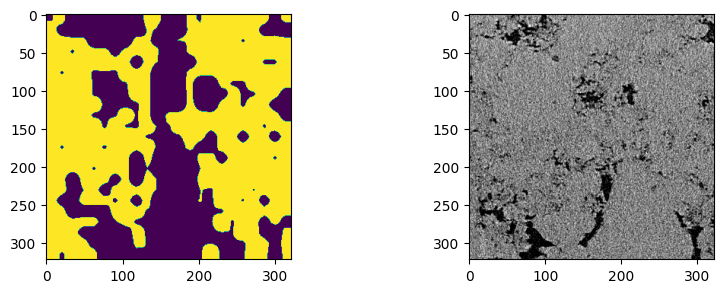

In [57]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.imshow(cluster_preds[indx].detach().cpu().permute(1, 2, 0).argmax(2))
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

In [184]:
output_logits = F.interpolate(cluster_preds.detach().cpu()[indx].unsqueeze(0), size=(H, W), mode="bilinear",
                                align_corners=False).squeeze()
output_probs = F.softmax(output_logits, dim=0).cpu().numpy()
c = output_probs.shape[0]
h = output_probs.shape[1]
w = output_probs.shape[2]

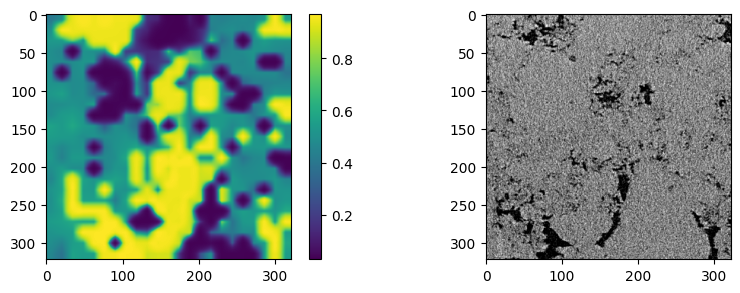

In [170]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.imshow(F.softmax(output_logits, dim=0).cpu().permute(1, 2, 0)[:, :, 0])
plt.colorbar()
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

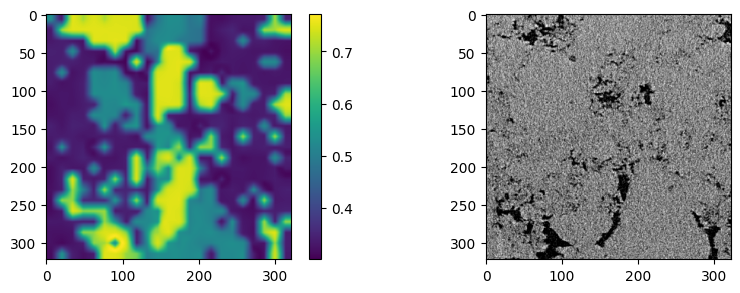

In [59]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.imshow(F.softmax(output_logits, dim=0).cpu().permute(1, 2, 0)[:, :, 0])
plt.colorbar()
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

In [185]:
U = utils.unary_from_softmax(output_probs)
U = np.ascontiguousarray(U)
MAX_ITER = 10
POS_W = 3
POS_XY_STD = 1
Bi_W = 4
Bi_XY_STD = 67
Bi_RGB_STD = 3

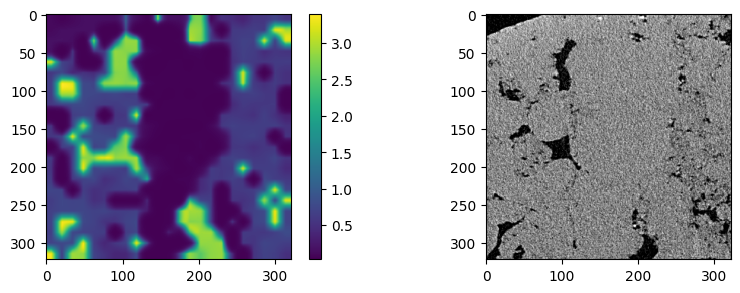

In [186]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.imshow(torch.from_numpy(U.reshape((c, h, w))).permute(1, 2, 0).numpy()[:, :, 1])
plt.colorbar()
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

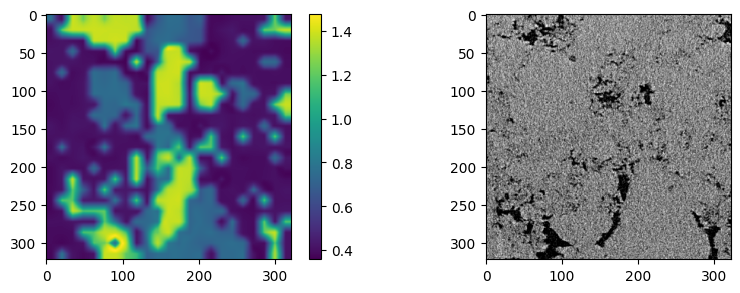

In [61]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.imshow(torch.from_numpy(U.reshape((c, h, w))).permute(1, 2, 0).numpy()[:, :, 1])
plt.colorbar()
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

In [187]:
d = dcrf.DenseCRF2D(w, h, c)
d.setUnaryEnergy(U)
d.addPairwiseGaussian(sxy=1, compat=3)
d.addPairwiseBilateral(sxy=67, srgb=Bi_RGB_STD, rgbim=image, compat=4)

Q = d.inference(10)
print(d.klDivergence(Q))
Q = np.array(Q).reshape((c, h, w))

-633275.5811372829


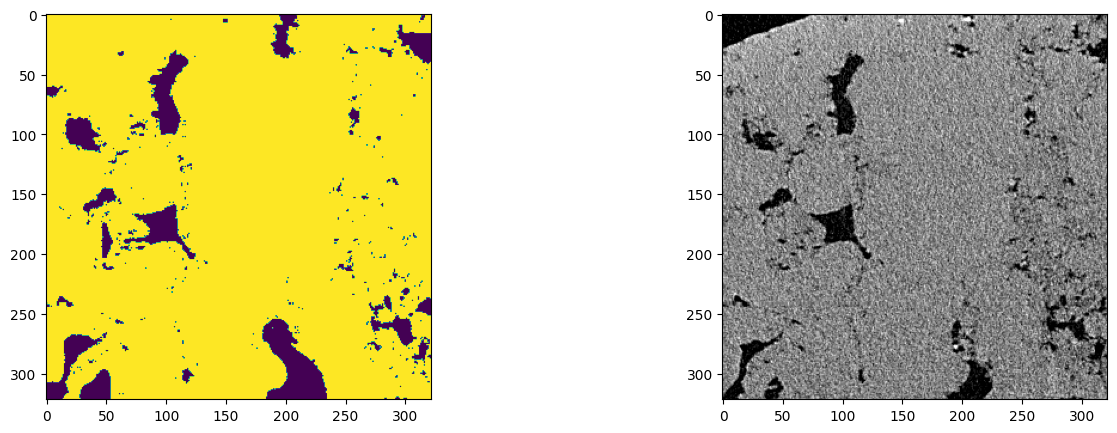

In [188]:
fig = plt.figure(figsize=(16, 11))
plt.subplot(221)
plt.imshow(np.argmax(Q, axis=0))
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

In [150]:
pred = torch.from_numpy(Q.round().astype(np.uint8)).unsqueeze(0)
miou = MeanIoU(num_classes=2, per_class=True)
value = miou(pred, label).numpy()

In [151]:
value

array([0.09161404, 0.5078507 ], dtype=float32)

In [64]:
true_label = Q.round().astype(np.uint8)

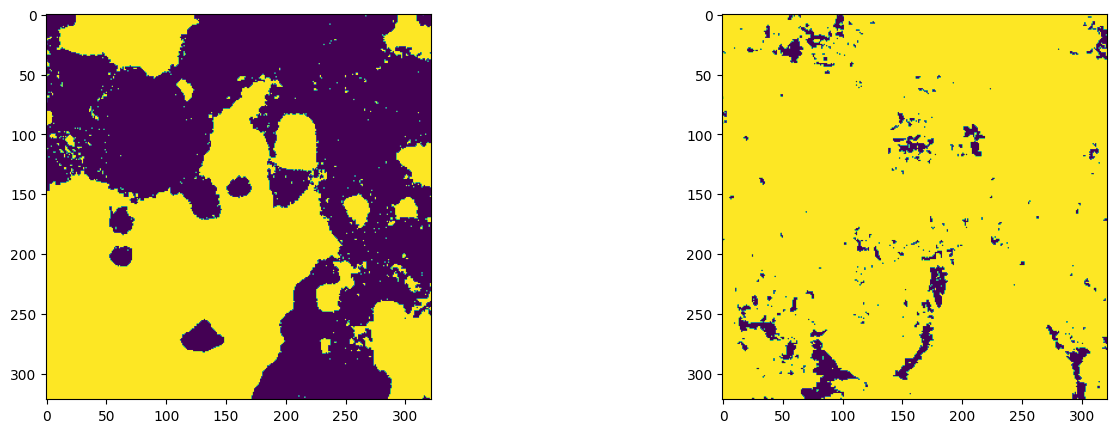

In [175]:
fig = plt.figure(figsize=(16, 11))
plt.subplot(221)
plt.imshow(Q.round()[0, :, :])
plt.subplot(222)
plt.imshow(true_label[1, :, :])
plt.show()

In [176]:
# -------------- 2.  Optuna objective ----------------
import optuna
label = torch.from_numpy(true_label).unsqueeze(0)
def objective(trial):
    # ── сэмплируем гиперпараметры ───────────────────
    sxy_bil   = trial.suggest_int("sxy_bil", 20, 120)
    srgb      = trial.suggest_int("srgb"   ,  3,  100)
    compat_b  = trial.suggest_int("compat_b", 5, 100)
    sxy_gau   = trial.suggest_int("sxy_gau",  1,  100)
    compat_g  = trial.suggest_int("compat_g", 1, 100)

    crf = dcrf.DenseCRF2D(w, h, c)
    crf.setUnaryEnergy(U)
    crf.addPairwiseGaussian(sxy=sxy_gau, compat=compat_g)
    crf.addPairwiseBilateral(sxy=sxy_bil, srgb=srgb,
                                rgbim=image, compat=compat_b)
    Q = crf.inference(10)
    Q = np.array(Q).reshape((c, h, w))
    pred = torch.from_numpy(Q.round().astype(np.uint8)).unsqueeze(0)
    miou = MeanIoU(num_classes=2, per_class=True)
    value = miou(pred, label).numpy()[0]
    return value

In [ ]:
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=15))
study.optimize(objective, n_trials=100, show_progress_bar=True)
print("🎯  Best params:", study.best_params)

In [178]:
print("🎯  Best params:", study.best_params)

🎯  Best params: {'sxy_bil': 48, 'srgb': 53, 'compat_b': 30, 'sxy_gau': 19, 'compat_g': 1}


In [189]:
d = dcrf.DenseCRF2D(w, h, c)
d.setUnaryEnergy(U)
d.addPairwiseGaussian(sxy=study.best_params['sxy_gau'], compat=study.best_params['compat_g'])
d.addPairwiseBilateral(sxy=study.best_params['sxy_bil'], srgb=study.best_params['srgb'], rgbim=image, compat=study.best_params['compat_b'])

Q = d.inference(10)
print(d.klDivergence(Q))
Q = np.array(Q).reshape((c, h, w))

-2986410.839882595


In [190]:
Q

array([[[7.54010095e-14, 8.88783405e-14, 4.02789718e-10, ...,
         6.73328526e-03, 8.03621969e-09, 5.99824688e-08],
        [9.17605225e-14, 1.02215254e-13, 1.16530158e-13, ...,
         8.77949824e-10, 5.33110445e-09, 8.60888694e-09],
        [1.11778405e-13, 1.23416061e-13, 3.04029561e-13, ...,
         1.54962917e-10, 1.91126810e-03, 2.08669013e-10],
        ...,
        [1.00000000e+00, 8.29375000e-04, 1.00000000e+00, ...,
         1.05328607e-10, 2.82325940e-10, 1.59440086e-10],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.21871901e-10, 3.32952776e-09, 1.84796470e-10],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         8.88109497e-09, 1.06007318e-08, 7.12700232e-10]],

       [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         9.93266702e-01, 1.00000000e+00, 9.99999881e-01],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 

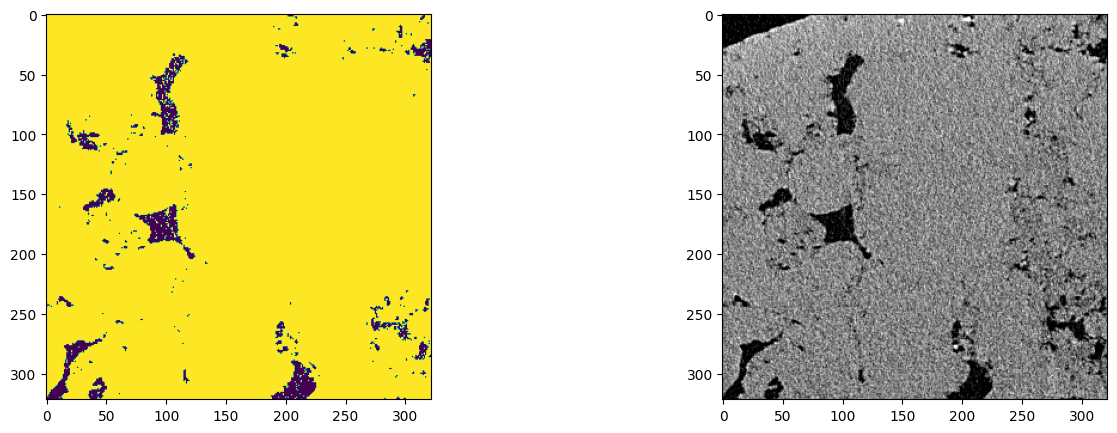

In [191]:
fig = plt.figure(figsize=(16, 11))
plt.subplot(221)
plt.imshow(np.argmax(Q, axis=0))
plt.subplot(222)
plt.imshow(img[indx].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
plt.show()

## clusterbook tests

In [ ]:
# net = net.to('cuda')
features = net(img.to('cuda'))[:, 1:, :]

In [37]:
codebook = np.load(r'D:\git\analytics_2\CAUSE\limestone_patches\modularity\dinomed_vit_base_16\Radio_DINO\modular.npy')
codebook = torch.tensor(codebook).to(cfg.device)

In [38]:
cfg.device

'cpu'

In [39]:
quant_ind_320 = quantize_index(features, codebook.to('cuda'))

In [40]:
quant_ind_320.shape

torch.Size([16, 400])

In [48]:
torch.randint(16, size=(1,))

tensor([14])

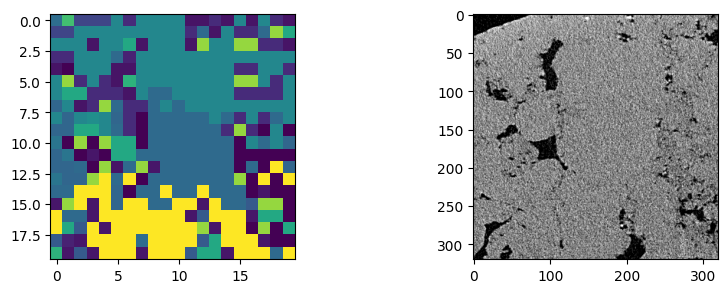

In [30]:
fig = plt.figure(figsize=(10, 7))
ind = 3
plt.subplot(221)
plt.imshow(quant_ind_320.reshape(16, 20, 20)[ind].cpu())
plt.subplot(222)
plt.imshow(img[ind].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')

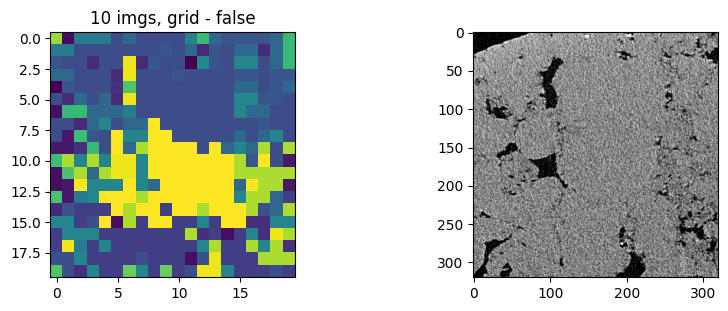

In [36]:
fig = plt.figure(figsize=(10, 7))
ind = 3
plt.subplot(221)
plt.imshow(quant_ind_320.reshape(16, 20, 20)[ind].cpu())
plt.title('10 imgs, grid - false')
plt.subplot(222)
plt.imshow(img[ind].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')

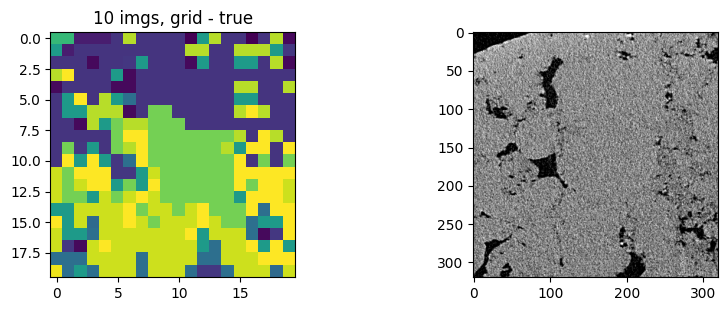

In [41]:
fig = plt.figure(figsize=(10, 7))
ind = 3
plt.subplot(221)
plt.imshow(quant_ind_320.reshape(16, 20, 20)[ind].cpu())
plt.title('10 imgs, grid - true')
plt.subplot(222)
plt.imshow(img[ind].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')